## Certified poisoning-robust training on the OCT-MNIST dataset

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import model_utils
from abstract_gradient_training import test_metrics
from labellines import labelLines

from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

In [2]:
results_dir = ".results/"
seed = 3
notebook_id = f"oct_sweep_poison_{seed}"
model_path = "models/medmnist_pretrained.ckpt"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Define the nominal config, model and dataloaders

In [3]:
clean_batchsize = 3000
drusen_batchsize = 3000
test_batchsize = 1000

nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=0.05,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="DEBUG",
    lr_decay=5.0,
    lr_min=0.001,
    early_stopping=False,
)


# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

/tmp/ipykernel_512517/3383902707.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [4]:
from abstract_gradient_training.poisoning import poison_certified_training

torch.manual_seed(0)

conv_layers = model[0:5]
linear_layers = model[5:-1]
conv_transform = model_utils.get_conv_model_transform(conv_layers)
param_l, param_n, param_u = model_utils.get_parameters(linear_layers)

# get dataloaders
dl_clean, dl_test_clean = oct_mnist.get_dataloaders(clean_batchsize, test_batchsize, exclude_classes=[2])
dl_drusen, dl_test_drusen = oct_mnist.get_dataloaders(drusen_batchsize, test_batchsize, exclude_classes=[0, 1, 3])
_, dl_test_all = oct_mnist.get_dataloaders(clean_batchsize, test_batchsize)

# evaluate the pre-trained model
param_l, param_n, param_u = model_utils.get_parameters(linear_layers)
drusen_acc = agt.test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_drusen)), transform=conv_transform
)
pretrained_acc_backdoor = agt.test_metrics.test_accuracy(
    param_l,
    param_n,
    param_u,
    *next(iter(dl_test_drusen)),
    transform=conv_transform,
    epsilon=0.001,
)
print(pretrained_acc_backdoor)
pretrained_acc = drusen_acc[1]
clean_acc = agt.test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_clean)), transform=conv_transform
)
all_acc = agt.test_metrics.test_accuracy(param_l, param_n, param_u, *next(iter(dl_test_all)), transform=conv_transform)

print("=========== Pre-trained model accuracy ===========", file=sys.stderr)
print(f"Class 2 (Drusen) : nominal = {drusen_acc[1]:.2g}", file=sys.stderr)
print(f"Classes 0, 1, 3  : nominal = {clean_acc[1]:.2g}", file=sys.stderr)
print(f"All Classes      : nominal = {all_acc[1]:.2g}", file=sys.stderr)

drusen_acc_backdoor = agt.test_metrics.test_accuracy(
    param_l,
    param_n,
    param_u,
    *next(iter(dl_test_drusen)),
    transform=conv_transform,
    epsilon=0.001,
)
print(f"Class 2 (Drusen) : backdoor = {drusen_acc_backdoor}", file=sys.stderr)

# fine-tune the model using abstract gradient training (keeping the convolutional layers fixed)
conf = copy.deepcopy(nominal_config)
conf.k_poison = 50
conf.epsilon = 0.01
param_l, param_n, param_u = poison_certified_training(
    linear_layers, conf, dl_drusen, dl_test_drusen, dl_clean=dl_clean, transform=conv_transform
)

# evaluate the fine-tuned model
drusen_acc = agt.test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_drusen)), transform=conv_transform
)
clean_acc = agt.test_metrics.test_accuracy(
    param_l, param_n, param_u, *next(iter(dl_test_clean)), transform=conv_transform
)
all_acc = agt.test_metrics.test_accuracy(param_l, param_n, param_u, *next(iter(dl_test_all)), transform=conv_transform)

print("=========== Fine-tuned model accuracy + bounds ===========", file=sys.stderr)
print(f"Class 2 (Drusen) : nominal = {drusen_acc[1]:.2g}, certified bound = {drusen_acc[0]:.2g}", file=sys.stderr)
print(f"Classes 0, 1, 3  : nominal = {clean_acc[1]:.2g}, certified bound = {clean_acc[0]:.2g}", file=sys.stderr)
print(f"All Classes      : nominal = {all_acc[1]:.2g}, certified bound = {all_acc[0]:.2g}", file=sys.stderr)

=========== Pre-trained model accuracy ===========
Class 2 (Drusen) : nominal = 0.37
Classes 0, 1, 3  : nominal = 0.83
All Classes      : nominal = 0.71
Class 2 (Drusen) : backdoor = (0.2760000228881836, 0.3680000305175781, 0.4440000355243683)
[AGT] [INFO    ] [11:14:01] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [11:14:01] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [11:14:01] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [11:14:01] 	Adversary feature-space budget: epsilon=0.01, k_poison=50
[AGT] [DEBUG   ] [11:14:01] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [11:14:01] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [11:14:01] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [11:14:01] Starting epoch 1
[AGT] [DEBUG   ] [11:14:01] Initi

(0.2760000228881836, 0.3680000305175781, 0.4440000355243683)


[AGT] [INFO    ] [11:14:02] Training batch 2: Network eval bounds=(0.91, 0.93, 0.94), W0 Bound=0.0107 
[AGT] [DEBUG   ] [11:14:03] Skipping batch 3 in epoch 1 (expected batchsize 6000, got 4754)
[AGT] [INFO    ] [11:14:03] Starting epoch 2
[AGT] [INFO    ] [11:14:03] Training batch 3: Network eval bounds=(0.9 , 0.92, 0.94), W0 Bound=0.0138 
[AGT] [INFO    ] [11:14:04] Training batch 4: Network eval bounds=(0.89, 0.91, 0.94), W0 Bound=0.0159 
[AGT] [DEBUG   ] [11:14:05] Skipping batch 3 in epoch 2 (expected batchsize 6000, got 4754)
[AGT] [INFO    ] [11:14:05] Final network eval: Network eval bounds=(0.88, 0.91, 0.94), W0 Bound=0.0175 
[AGT] [INFO    ] [11:14:05] =================== Finished Poison Certified Training ===================
=========== Fine-tuned model accuracy + bounds ===========
Class 2 (Drusen) : nominal = 0.91, certified bound = 0.88
Classes 0, 1, 3  : nominal = 0.81, certified bound = 0.8
All Classes      : nominal = 0.84, certified bound = 0.82


### Helper functions to perform the sweep

In [5]:
def run_with_config(config, backdoor=False):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                linear_layers, config, dl_drusen, dl_test_drusen, dl_public=dl_clean, transform=conv_transform
            )
        else:
            param_l, param_n, param_u = agt.poison_certified_training(
                linear_layers, config, dl_drusen, dl_test_drusen, dl_clean=dl_clean, transform=conv_transform
            )
        torch.save((param_l, param_n, param_u), fname)
    # get nominal accuracy (on the Drusen class) and percent certified (on the entire test set)
    test_eps = config.epsilon if backdoor else 0.0
    accuracy = test_metrics.test_accuracy(
        param_l,
        param_n,
        param_u,
        *next(iter(dl_test_drusen)),
        transform=conv_transform,
        epsilon=test_eps,
    )
    del param_l, param_n, param_u
    torch.cuda.empty_cache()
    return accuracy

### Perform the sweep over different gamma and k values

Experiments:

1. Feature poisoning with bounded adversary
2. Label flipping with bounded adversary
3. Feature + label flipping with bounded adversary
4. Feature + label poisoning with unbounded adversary

In [6]:
# experiment 1
k_poisons = list(range(0, 601, 20))

# k_poisons_1 = [0, 50, 100, 150, 200, 250, 300]
# k_poisons_1 = [0, 150, 300, 500]
epsilons_1 = [0.01, 0.02, 0.1]

results_1 = {}

config = copy.deepcopy(nominal_config)

for epsilon in epsilons_1:
    tmp_results = {}
    for k_poison in k_poisons:
        config.k_poison = k_poison
        config.epsilon = epsilon
        tmp_results[k_poison] = run_with_config(config)
    results_1[epsilon] = tmp_results

[AGT] [INFO    ] [11:14:10] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [11:14:10] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [11:14:10] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [11:14:10] 	Adversary feature-space budget: epsilon=0.01, k_poison=0
[AGT] [DEBUG   ] [11:14:10] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [11:14:10] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [11:14:10] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [11:14:10] Starting epoch 1
[AGT] [DEBUG   ] [11:14:10] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [11:14:10] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [11:14:11] Training batch 2: Network eval bounds=(0.94, 0.94, 0.94), W0 Bound=0.0 
[AGT] [D

In [7]:
# experiment 3
# k_poisons_3 = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
# k_poisons_3 = [0, 500, 1000]
results_3 = {}

config = copy.deepcopy(nominal_config)

for k_poison in k_poisons:
    config.label_k_poison = k_poison
    results_3[k_poison] = run_with_config(config)

[AGT] [INFO    ] [11:36:31] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [11:36:31] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [11:36:31] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [11:36:31] 	Adversary feature-space budget: epsilon=0, k_poison=0
[AGT] [DEBUG   ] [11:36:31] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [11:36:31] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [11:36:31] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [11:36:32] Starting epoch 1
[AGT] [DEBUG   ] [11:36:32] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [11:36:32] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [11:36:32] Training batch 2: Network eval bounds=(0.94, 0.94, 0.94), W0 Bound=0.0 
[AGT] [DEBU

In [8]:
# experiment 4

# k_poisons_4 = [0, 50, 100, 150, 200, 250, 300]
# k_poisons_4 = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500]
clip_gammas = [0.5, 1.0, 4.0]

results_4 = {}

config = copy.deepcopy(nominal_config)
for clip_gamma in clip_gammas:
    tmp_results = {}
    for k_poison in k_poisons:
        config.k_private = k_poison
        config.clip_gamma = clip_gamma
        tmp_results[k_poison] = run_with_config(config)
    results_4[clip_gamma] = tmp_results

[AGT] [INFO    ] [11:38:56] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [11:38:56] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [11:38:56] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [11:38:56] 	Adversary feature-space budget: epsilon=0, k_poison=0
[AGT] [DEBUG   ] [11:38:56] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [11:38:56] 	Clipping: gamma=0.5, method=clamp
[AGT] [DEBUG   ] [11:38:56] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [11:38:56] Starting epoch 1
[AGT] [DEBUG   ] [11:38:56] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [11:38:56] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [11:38:56] Training batch 2: Network eval bounds=(0.7 , 0.7 , 0.7 ), W0 Bound=0.0 
[AGT] [DEBU

In [9]:
# experiment 5

# k_poisons_5 = [0, 50, 100, 150, 200, 250, 300]
# k_poisons_5 = [0, 50, 100, 150, 300, 350, 400, 450, 500]
epsilons_1 = [0.003, 0.006, 0.009]

results_5 = {}

config = copy.deepcopy(nominal_config)

for epsilon in epsilons_1:
    tmp_results = {}
    for k_poison in k_poisons:
        config.k_poison = k_poison
        config.epsilon = epsilon
        tmp_results[k_poison] = run_with_config(config, backdoor=True)
    results_5[epsilon] = tmp_results

[AGT] [INFO    ] [11:44:57] =================== Starting Poison Certified Training ===================
[AGT] [DEBUG   ] [11:44:57] 	Optimizer params: n_epochs=2, learning_rate=0.05, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [11:44:57] 	Learning rate schedule: lr_decay=5.0, lr_min=0.001, early_stopping=False
[AGT] [DEBUG   ] [11:44:57] 	Adversary feature-space budget: epsilon=0.003, k_poison=0
[AGT] [DEBUG   ] [11:44:57] 	Adversary label-space budget: label_epsilon=0, label_k_poison=0, poison_target=-1
[AGT] [DEBUG   ] [11:44:57] 	Clipping: gamma=inf, method=clamp
[AGT] [DEBUG   ] [11:44:57] 	Bounding methods: forward=interval, loss=binary_cross_entropy, backward=interval
[AGT] [INFO    ] [11:44:57] Starting epoch 1
[AGT] [DEBUG   ] [11:44:57] Initialising dataloader batchsize to 6000
[AGT] [INFO    ] [11:44:57] Training batch 1: Network eval bounds=(0.37, 0.37, 0.37), W0 Bound=0.0 
[AGT] [INFO    ] [11:44:57] Training batch 2: Network eval bounds=(0.94, 0.94, 0.94), W0 Bound=0.0 
[AGT] [

### Plot the results

In [ ]:
palette = sns.color_palette(palette="Dark2", n_colors=12)
lb_color = list(iter(sns.color_palette(palette="deep")))[-1]
ub_color = list(iter(sns.color_palette(palette="deep")))[-2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.3)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
labelsize = 22

def plot_experiment(results, ax, type=1, label=r"\epsilon"):
    if type == 1:
        colors = iter(palette)
        for epsilon, results in results.items():
            nom_accs = [res[1] for res in results.values()]
            cert_accs = [res[0] for res in results.values()]
            k_poisons = list(results.keys())
            color = next(colors)
            if epsilon == 0.01:
                ax.plot(k_poisons, nom_accs, linestyle="--", color=color)
            ax.plot(k_poisons, cert_accs, label=fr"${label}={epsilon}$", color=color)
    elif type == 2:
        colors = iter(palette)
        nom_accs = [res[1] for res in results.values()]
        k_poisons = list(results.keys())
        cert_accs = [res[0] for res in results.values()]
        color = next(colors)
        ax.plot(k_poisons, nom_accs, color=color, linestyle="--")
        ax.plot(k_poisons, cert_accs, color=color)
    elif type == 3:
        colors = iter(palette)
        for epsilon, results in results.items():
            nom_accs = [res[1] for res in results.values()]
            cert_accs = [res[0] for res in results.values()]
            k_poisons = list(results.keys())
            color = next(colors)
            ax.plot(k_poisons, nom_accs, color=color, linestyle="--")
            ax.plot(k_poisons, cert_accs, label=fr"${label}={epsilon}$", color=color)
    elif type == 4:
        colors = iter(palette)
        for epsilon, results in results.items():
            cert_accs = [res[0] for res in results.values()]
            nom_accs = [cert_accs[0] for res in results.values()]
            k_poisons = list(results.keys())
            color = next(colors)
            ax.plot(k_poisons, nom_accs, color=color, linestyle="--")
            ax.plot(k_poisons, cert_accs, label=fr"${label}={epsilon}$", color=color)

fig, ax = plt.subplots(
    1,
    5,
    figsize=(20, 15),
    layout="constrained",
    width_ratios=[1, 1, 1, 0.01, 1],
    sharey=False,
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)
[a.set_box_aspect(1) for a in ax]

ax[3].set_visible(False)
ax[0].set_title("Feature Poisoning\n(Bounded Adversary)", pad=15)
ax[0].set_xlabel("Attack Size ($n$)")
plot_experiment(results_1, ax[0])
labelLines(ax[0].get_lines(), align=False, drop_label=True, fontsize=labelsize, xvals=[500, 430, 320])

# ax[1].set_title("Label Flipping", pad=15)
# ax[1].set_xlabel("$n=m$")
# plot_experiment(results_2, ax[1])
# labelLines(ax[1].get_lines(), align=False, drop_label=True, fontsize=labelsize)

ax[1].set_title("Label Poisoning\n(Bounded Adversary)", pad=15)
ax[1].set_xlabel("Attack Size ($m$)")
plot_experiment(results_3, ax[1], type=2)

ax[2].set_title("Feature + Label Poisoning\n(Unbounded Adversary)", pad=15)
ax[2].set_xlabel("Attack Size ($n$)")
plot_experiment(results_4, ax[2], label=r"\kappa", type=3)
labelLines(ax[2].get_lines(), align=False, drop_label=True, fontsize=labelsize, xvals=[500, 260, 75])

plot_experiment(results_5, ax[4], label=r"\epsilon", type=4)
labelLines(ax[4].get_lines(), align=False, drop_label=True, fontsize=labelsize, xvals=[480, 410, 300])

ax[4].set_title("Feature Poisoning\n(Bounded Adversary)", pad=15)
ax[4].set_xlabel("Attack Size ($n$)")
ax[4].set_ylabel("Backdoor Accuracy", fontsize="large")
ax[1].plot([], [], color="grey", label="Fine-Tuned Models", linestyle="--")

for i in range(5):
    if i in [1, 2]:
        ax[i].set_yticklabels([])
    ax[i].set_xticks([0, 200, 400, k_poisons[-1]])
    ax[i].set_ylim(0, 1.0)
    ax[i].set_xlim(0, k_poisons[-1])
    # ax[i].set_xticks([0, 50, 100, 150])
    # ax[i].set_xticklabels([0, 50, 100, 150])
    if i == 4:
        continue
    ax[i].axhline(pretrained_acc, label="Pre-Trained Model", color=lb_color, linestyle="-.")


ax[1].legend(loc="lower right", fontsize=labelsize)
ax[0].set_ylabel("Certified Accuracy", fontsize="large")

plt.savefig(f".figures/oct_mnist_poisoning.pdf", bbox_inches="tight", dpi=300)

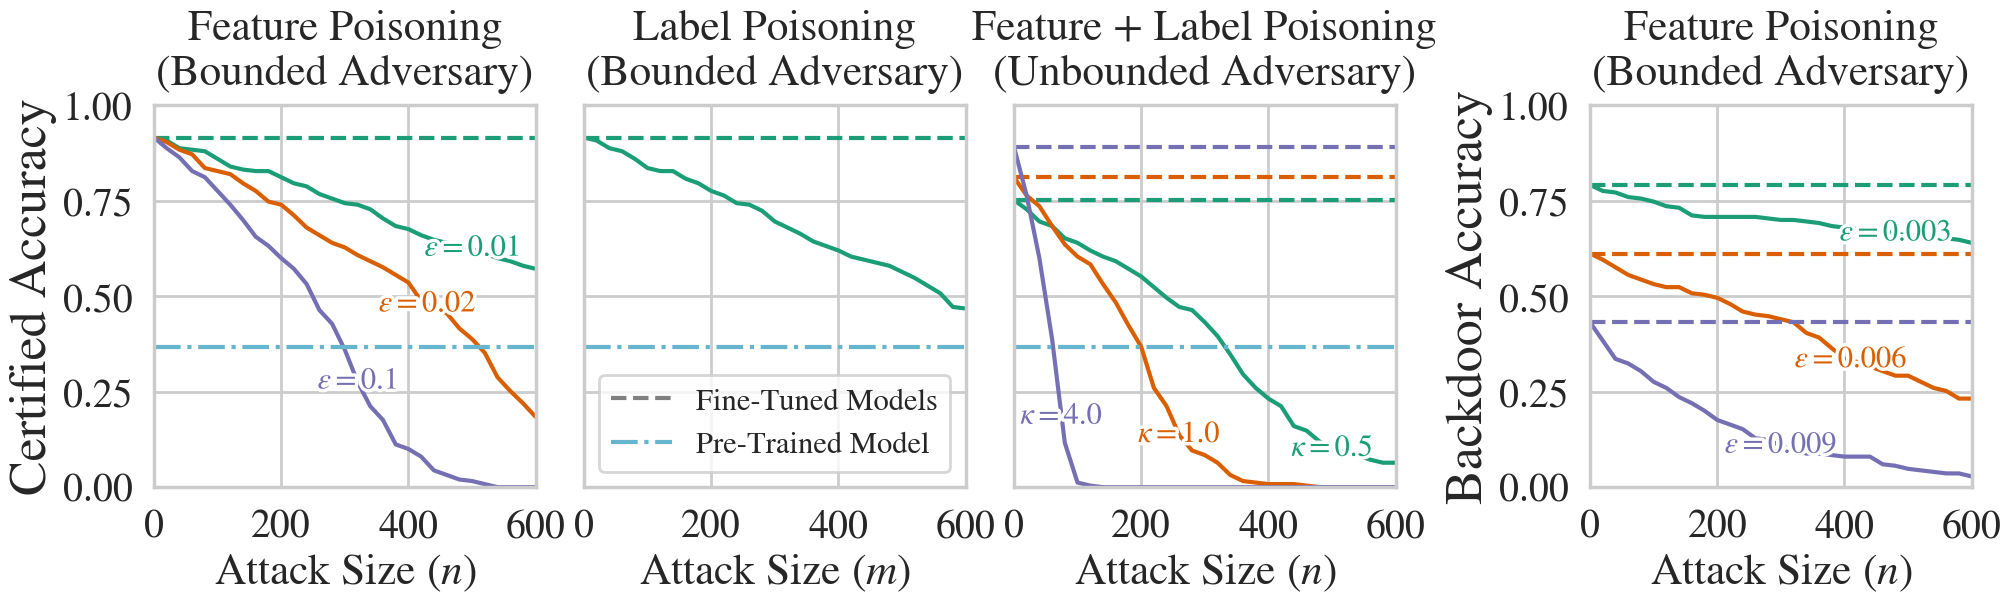